<a href="https://colab.research.google.com/github/ewuerfel66/DS-Unit-2-Applied-Modeling/blob/master/EricWuerfel_LogLinearRegressionAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Log Linear Regression

## CAT Tube Assemblies

# Imports

In [0]:
# the usual suspects
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

# Data

In [2]:
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip

--2019-07-22 22:30:22--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/caterpillar/caterpillar-tube-pricing.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 823789 (804K) [application/zip]
Saving to: ‘caterpillar-tube-pricing.zip.4’

caterpillar-tube-pr 100%[===================>] 804.48K  --.-KB/s    in 0.08s   

2019-07-22 22:30:22 (10.4 MB/s) - ‘caterpillar-tube-pricing.zip.4’ saved [823789/823789]



In [3]:
!ls *.zip

caterpillar-tube-pricing.zip  data.zip


In [4]:
!unzip caterpillar-tube-pricing.zip

Archive:  caterpillar-tube-pricing.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [19]:
!unzip data.zip

Archive:  data.zip
replace competition_data/bill_of_materials.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
# Get filenames and shapes
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    print(path, df.shape)

competition_data/comp_tee.csv (4, 14)
competition_data/test_set.csv (30235, 8)
competition_data/comp_threaded.csv (194, 32)
competition_data/comp_other.csv (1001, 3)
competition_data/comp_sleeve.csv (50, 10)
competition_data/tube_end_form.csv (27, 2)
competition_data/train_set.csv (30213, 8)
competition_data/comp_boss.csv (147, 15)
competition_data/comp_adaptor.csv (25, 20)
competition_data/comp_nut.csv (65, 11)
competition_data/type_connection.csv (14, 2)
competition_data/bill_of_materials.csv (21198, 17)
competition_data/specs.csv (21198, 11)
competition_data/type_component.csv (29, 2)
competition_data/type_end_form.csv (8, 2)
competition_data/comp_elbow.csv (178, 16)
competition_data/comp_float.csv (16, 7)
competition_data/comp_straight.csv (361, 12)
competition_data/components.csv (2048, 3)
competition_data/tube.csv (21198, 16)
competition_data/comp_hfl.csv (6, 9)


# test/train/val split

In [0]:
trainval = pd.read_csv('competition_data/train_set.csv')
test = pd.read_csv('competition_data/test_set.csv')

In [0]:
# get unique ids for trainval and test sets
trainval_tube_assemblies = trainval['tube_assembly_id'].unique()
test_tube_assemblies = test['tube_assembly_id'].unique()

In [0]:
# do train/val split for tube_assembly_ids
# this ensures that the validation set has unknown tube assemblies
train_tube_assemblies, val_tube_assemblies = train_test_split(
    trainval_tube_assemblies, random_state=24
)

In [24]:
# use split tube assembly ids to split the data
train = trainval[trainval.tube_assembly_id.isin(train_tube_assemblies)]
val = trainval[trainval.tube_assembly_id.isin(val_tube_assemblies)]
train.shape, val.shape, trainval.shape

((22769, 8), (7444, 8), (30213, 8))

In [0]:
assert(len(train) + len(val) == len(trainval))

# Baseline model: median

In [0]:
# define our metric
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [27]:
print("Mean:", train['cost'].mean())
print("Median:", train['cost'].median())

Mean: 13.51946533848239
Median: 6.535056726184179


In [28]:
# The data is pretty skewed so we should use the median
target = 'cost'
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.median())
print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))

Validation RMSLE, Mean Baseline: 0.8366241688684566


# Data Wrangling

In [29]:
for path in glob('competition_data/*.csv'):
    df = pd.read_csv(path)
    shared_columns = set(df.columns) & set(train.columns)
    if shared_columns:
      print(path, df.shape)
      print(df.columns.tolist(), '\n')

competition_data/test_set.csv (30235, 8)
['id', 'tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity'] 

competition_data/train_set.csv (30213, 8)
['tube_assembly_id', 'supplier', 'quote_date', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'cost'] 

competition_data/bill_of_materials.csv (21198, 17)
['tube_assembly_id', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8'] 

competition_data/specs.csv (21198, 11)
['tube_assembly_id', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'spec10'] 

competition_data/tube.csv (21198, 16)
['tube_assembly_id', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end

In [0]:
# Wrangle Data
def wrangle(X):
    # Copy the dataframe
    X = X.copy()
    
    # date features
    X['quote_date'] = pd.to_datetime(X['quote_date'], infer_datetime_format=True)
    X['quote_date_year'] = X['quote_date'].dt.year
    X['quote_date_month'] = X['quote_date'].dt.month
    X = X.drop(columns='quote_date')
    
    # tube data
    tube = pd.read_csv('competition_data/tube.csv')
    X = X.merge(tube, how='left')
    
    # specs data
    specs = pd.read_csv('competition_data/specs.csv')
    X = X.merge(specs, how='left')
    
    # drop tube_assembly_id
    X = X.drop(columns='tube_assembly_id')
    
    return X

In [0]:
# wrangle train/val/test
train_wrangled = wrangle(train)
val_wrangled = wrangle(val)
test_wrangled = wrangle(test)

# RFC specs

In [32]:
# Import category encoders
!pip install category_encoders
import category_encoders as ce

In [33]:
# Define features and target
target = 'cost'
features = train_wrangled.columns.drop(target)
print('Features:', features.tolist())

Features: ['supplier', 'annual_usage', 'min_order_quantity', 'bracket_pricing', 'quantity', 'quote_date_year', 'quote_date_month', 'material_id', 'diameter', 'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket', 'other', 'spec1', 'spec2', 'spec3', 'spec4', 'spec5', 'spec6', 'spec7', 'spec8', 'spec9', 'spec10']


In [0]:
# create X_train, X_val, X_test, y_train_log
X_train = train_wrangled[features]
X_val = val_wrangled[features] 
X_test = test_wrangled[features]
y_train_log = np.log1p(y_train)

In [0]:
# Encode
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)


In [0]:
# Impute
imputer = SimpleImputer(np.nan, strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_encoded.values), columns=X_train.columns.values)
X_val_imputed = pd.DataFrame(imputer.transform(X_val_encoded.values), columns=X_train.columns.values)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_encoded.values), columns=X_train.columns.values)

In [37]:
X_test_imputed.head()

,supplier,annual_usage,min_order_quantity,bracket_pricing,quantity,quote_date_year,quote_date_month,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,end_a,end_x,num_boss,num_bracket,other,spec1,spec2,spec3,spec4,spec5,spec6,spec7,spec8,spec9,spec10
0,1.0,0.0,0.0,1.0,1.0,2013.0,6.0,6.0,12.7,1.65,164.0,5.0,38.1,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,0.0,0.0,1.0,2.0,2013.0,6.0,6.0,12.7,1.65,164.0,5.0,38.1,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,0.0,0.0,1.0,5.0,2013.0,6.0,6.0,12.7,1.65,164.0,5.0,38.1,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,0.0,0.0,1.0,10.0,2013.0,6.0,6.0,12.7,1.65,164.0,5.0,38.1,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,0.0,0.0,1.0,25.0,2013.0,6.0,6.0,12.7,1.65,164.0,5.0,38.1,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
# instantiate model
model = RandomForestRegressor(n_estimators=100, random_state=24, n_jobs=-1)

In [39]:
# fit model
model.fit(X_train_imputed, y_train_log)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=24, verbose=0,
                      warm_start=False)

In [0]:
# create log_predictions
y_pred_log = model.predict(X_val_imputed)

In [0]:
# transform log_predictions back to predictions
y_pred = np.expm1(y_pred_log)

In [42]:
print("RMSLE:", rmsle(y_val, y_pred))

RMSLE: 0.29558106341984386


# Export Predictions

In [0]:
# Create y_pred_log
y_pred_log = model.predict(X_test_imputed)

In [0]:
# transform log_predictions back to predictions
y_pred = np.expm1(y_pred_log)

In [0]:
sample_df = pd.read_csv('sample_submission.csv')

In [46]:
sample_df.head()

,id,cost
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [47]:
# Send predictions to df
submission_df = pd.DataFrame()

# Add columns
submission_df['id'] = True
submission_df['id'] = [x for x in range(1, (len(X_test_imputed)+1))]

submission_df['cost'] = True
submission_df['cost'] = y_pred

submission_df.head()

,id,cost
0,1,22.953519
1,2,13.548427
2,3,7.743642
3,4,5.492442
4,5,4.308959


In [0]:
submission_df.to_csv('randomforest_1', index=False)

# Feature Importances

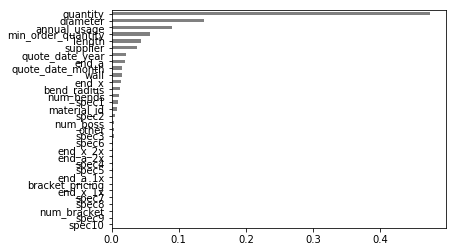

In [49]:
importances = pd.Series(model.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

In [54]:
importances.sort_values(ascending=False)[:10]

quantity              0.474600
diameter              0.137669
annual_usage          0.090312
min_order_quantity    0.057599
length                0.044263
supplier              0.038310
quote_date_year       0.021019
end_a                 0.020397
quote_date_month      0.015379
wall                  0.015165
dtype: float64

# RFC Top 10